## Notebook implementation: High-dimensional statistical arbitrage with factor models and stochastic control
### Paper author: Jorge Guijarro-Ordonez

This notebook is based on the above mentioned paper

In [1]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
import matplotlib.pyplot as plt
from tqdm import tqdm
%reload_ext autoreload
%autoreload 2

### Part 1: Monte carlo simulations of high dimensional Ornstein-Uhlenbeck processes

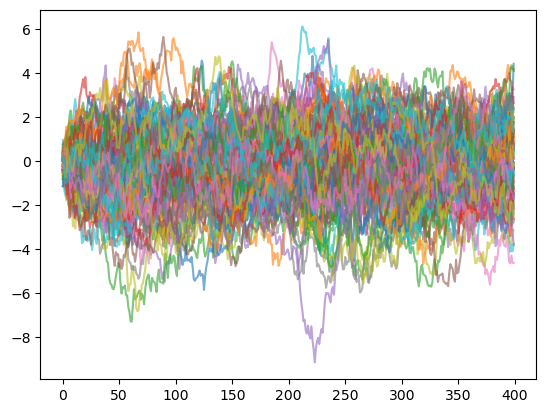

In [2]:
# Same parameters are used as in the paper 
N       = 100
T       = 20
L       = 400
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

# Initialise the process
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
X       = np.zeros((N,L))
Y       = np.zeros((N,L))

# Perform a monte carlo simulation
for idx in range(L):
    X[:,idx] = process.step()
    Y[:,idx] = process.Yt
plt.plot(np.transpose(X),alpha=0.6)
plt.show()

### Part 2: stochastic control solutions applied to the monte carlo paths

In [3]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
Wealth = np.zeros((M,L,len(gammas)))

# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi       = np.zeros((N,L,len(gammas)))
    W        = np.zeros((L,len(gammas)))
    W[:,0]   = W0
    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t = pi[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W[idx-1,count] - pi[:,idx-1,count].transpose() @ p)*r * delta_t
                W[idx,count] = W[idx-1,count] + dW_t
        
        # Simulating the exponential-utility strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t = sigma_perp_inv @ (theta @ (mu - X_t) - p*r) / (gamma*np.exp(r*(T-t))) + theta.transpose() @ (sigma_perp_inv) /(gamma*np.exp(r*(T-t))) @ (theta @ (mu-X_t) - p*r) * (T-t) - theta @ p *r*(T-t)**2/2
            pi[:,idx, count] = pi_t.reshape((1,-1))

    Wealth[sim,:,:] = W
    
avg_W = np.mean(Wealth,axis=0)

100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


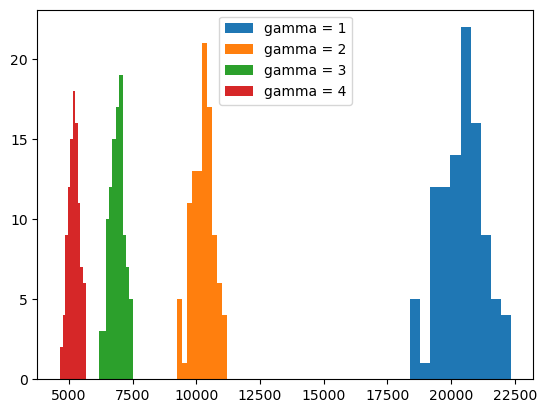

In [4]:
plt.hist(Wealth[:,-1,0])
plt.hist(Wealth[:,-1,1])
plt.hist(Wealth[:,-1,2])
plt.hist(Wealth[:,-1,3])
plt.legend(['gamma = 1','gamma = 2','gamma = 3','gamma = 4'])
plt.show()

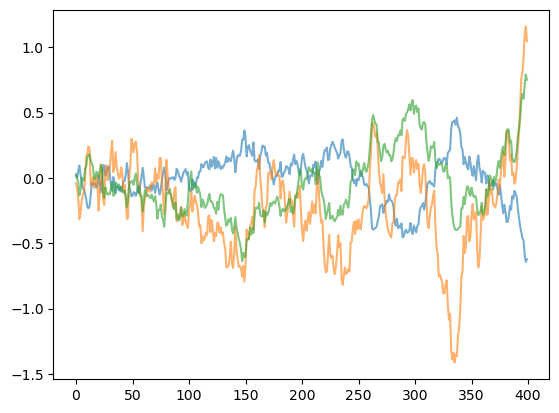

In [284]:
plt.plot(np.transpose(X),alpha=0.6)
plt.show()